In [1]:
import matplotlib.pyplot as plt
import numpy as np
# from matrixopt.models import *
from math import pi, sqrt
WL = 405e-9

# Toptica OE-000592 je real -> https://www.toptica.com/products/optical-isolators-photonicals/photonicals/optical-fibers
MODAL_FIELD_DIAMETER = 3.5e-6
NA = 0.07

# Přepočty z https://www.thorlabs.com/newgrouppage9.cfm?objectgroup_id=14204
def calculate_rayleigh_range(mfd, wave_length) -> float:
    return pi / wave_length * (mfd / 2)**2

def calculate_q_param(z, z_r, z_waist=0) -> complex:
    return complex(z - z_waist, z_r)

def calculate_fiber_beam_radius_at_z(z, z_r, mfd) -> float:
    return mfd/2 * sqrt(1 + (z/z_r)**2)

Text(0, 0.5, 'Beam diameter [mm]')

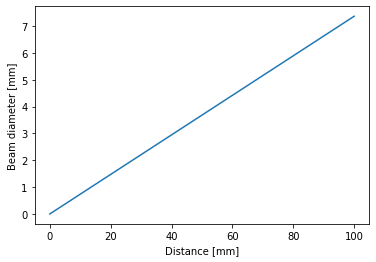

In [2]:

z_r = calculate_rayleigh_range(MODAL_FIELD_DIAMETER, WL)
# q = calculate_q_param()
distance_in_mm = np.linspace(0,100,100)
beam_radius = [calculate_fiber_beam_radius_at_z(d*10**(-3), z_r, MODAL_FIELD_DIAMETER) for d in distance_in_mm]
beam_radius_in_mm = [br*10**(3) for br in beam_radius]
plt.plot(distance_in_mm, beam_radius_in_mm)
plt.xlabel("Distance [mm]")
plt.ylabel("Beam diameter [mm]")


In [3]:
def get_beam_diameter(q_start: complex, wl, n, z: float) -> float:
    """_summary_

    Args:
        q_start (complex): q param ..
        wl (_type_): wavelength
        n (_type_): refractive index
    """
    q_z = q_start + z
    imag_inverse_q_z = (1/q_z).imag
    return sqrt(-(wl / (n * pi * imag_inverse_q_z)))


# Propagace systémem

In [12]:
from matrixopt.matrix_optics import *
q_in = calculate_q_param(0,z_r)

fs1 = FreeSpace(d=1e-2)
lens1 = ThinLens(f=2.5e-2)

op = OpticalPath(fs1, lens1)
q_out = op.propagate(q_in)



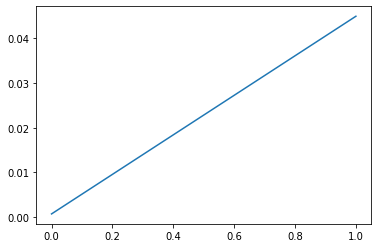

In [14]:
zs = np.linspace(0,100e-2,1000)
diameters = [get_beam_diameter(q_out, WL, 1, z) for z in zs]
diameters_in_mm = [d*10**(-3) for d in diameters]

plt.plot(zs, diameters)
